# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

## Methods

**Today**
- last observed value
- simple average
- moving average
- Holt's linear trend
- previous cycle

**Tomorrow**
- Prophet

**Appendix and Google**
- ARIMA (ARIMAX)
- Holt Winters
- Exponential Smoothing

### Goal
Build forecasting methods to predict number of items sold AND total dollars sold. 

___________________________________
___________________________________

## Wrangle

**Set up Environment**

In [153]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

**Acquire Store Item Demand Data**

In [154]:
df = pd.read_csv('store_item_demand.csv')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 12 columns):
sale_id          913000 non-null int64
sale_date        913000 non-null object
store_id         913000 non-null int64
item_id          913000 non-null int64
sale_amount      913000 non-null int64
item_brand       913000 non-null object
item_name        913000 non-null object
item_price       913000 non-null float64
store_address    913000 non-null object
store_zipcode    913000 non-null int64
store_city       913000 non-null object
store_state      913000 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 83.6+ MB


**Prepare Data**

1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [156]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).\
            sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold', 'items_sold']].sum().\
            reset_index().set_index('ds')

df = prep_data(df)


In [157]:
df = df[df.index != '2016-02-29']

___________________________________

## Split


In [158]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)

In [159]:
validate_end_index = train_size + validate_size
print(train_size)
print(validate_size)
print(test_size) 
print(validate_end_index)

912
547
366
1459


In [160]:
# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

**Verify splits**

In [161]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [162]:
print(df.head(1) == train.head(1))

            dollars_sold  items_sold
ds                                  
2013-01-01          True        True


In [163]:
print(train.tail(1).index)
print(validate.head(1).index)

DatetimeIndex(['2015-07-01'], dtype='datetime64[ns]', name='ds', freq=None)
DatetimeIndex(['2015-07-02'], dtype='datetime64[ns]', name='ds', freq=None)


In [164]:
print(validate.tail(1).index)
print(test.head(1).index)

DatetimeIndex(['2016-12-30'], dtype='datetime64[ns]', name='ds', freq=None)
DatetimeIndex(['2016-12-31'], dtype='datetime64[ns]', name='ds', freq=None)


In [165]:
print(test.tail(1).index)
print(df.tail(1).index)

DatetimeIndex(['2017-12-31'], dtype='datetime64[ns]', name='ds', freq=None)
DatetimeIndex(['2017-12-31'], dtype='datetime64[ns]', name='ds', freq=None)


In [166]:
train.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


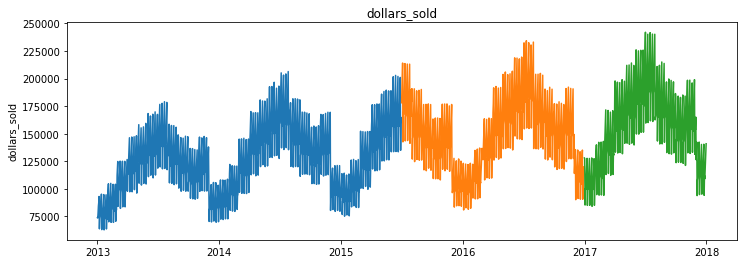

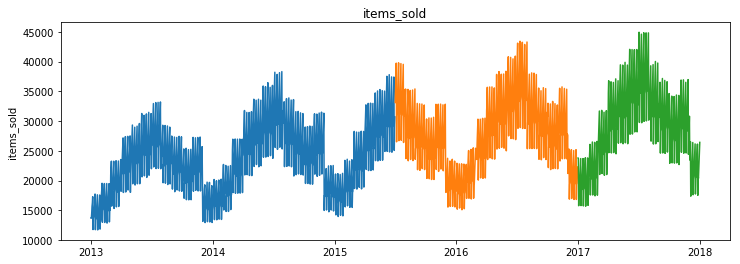

In [167]:
for col in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

___________________________________

## Forecast 

### Last observed value

**Make Predictions**

In [168]:
# items sold
items = train['items_sold'][-1:][0]

# dollars
dollars = round(train['dollars_sold'][-1:][0], 2)

yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]},
                       index = validate.index
                      )

yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-02,30703,164573.2
2015-07-03,30703,164573.2
2015-07-04,30703,164573.2
2015-07-05,30703,164573.2
2015-07-06,30703,164573.2


**Plot Actual vs. Predicted Values**

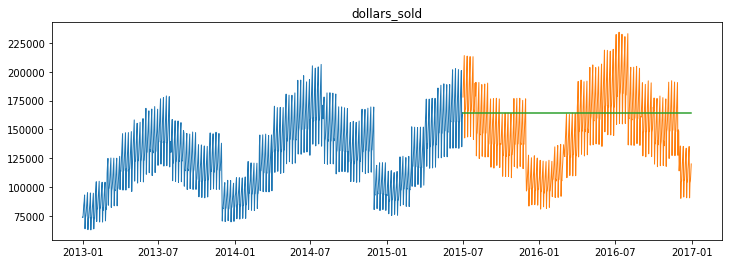

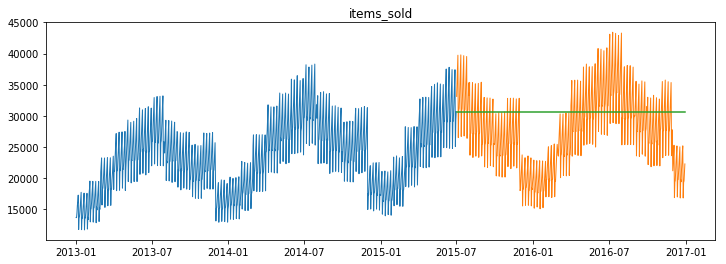

In [169]:
for col in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[col], label = 'Train', linewidth = 1)
    plt.plot(validate[col], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[col])
    plt.title(col)
    plt.show()

**Evaluate** 

Evaluate: Compute RMSE

Compare: Add evaluation metrics to a dataframe for comparison across forecasting methods. 

In [170]:
for col in train.columns:
    print(col, "rmse: ", round(sqrt(mean_squared_error(validate[col], yhat_df[col])), 0))

dollars_sold rmse:  35402.0
items_sold rmse:  6621.0


We know we are going to need to evaluate over multiple methods, so let's make a function for this. 

1. evaluate(target_var)
2. plot_and_eval(target_var)
3. append_eval_df(model_type, target_var)

In [171]:
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])

In [172]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [173]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [174]:
# test evaluate function
for col in train.columns:
    print(evaluate(col))

35402.0
6621.0


items_sold -- RMSE: 6621


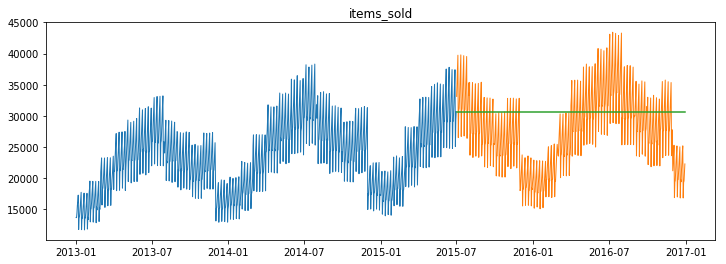

In [175]:
# test plot & eval function
plot_and_eval('items_sold')

In [176]:
eval_df.head()

,model_type,target_var,rmse


In [177]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [178]:
eval_df = append_eval_df(model_type = 'Last Value', target_var = 'items_sold')
eval_df = append_eval_df(model_type = 'Last Value', target_var = 'dollars_sold')
eval_df

,model_type,target_var,rmse
0,Last Value,items_sold,6621.0
1,Last Value,dollars_sold,35402.0


___________________________________

### Simple Average

**Make Predictions**

In [179]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold': [items],
                            'dollars_sold': [dollars],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [180]:
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02,23717.94,127517.85
2015-07-03,23717.94,127517.85


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 39664


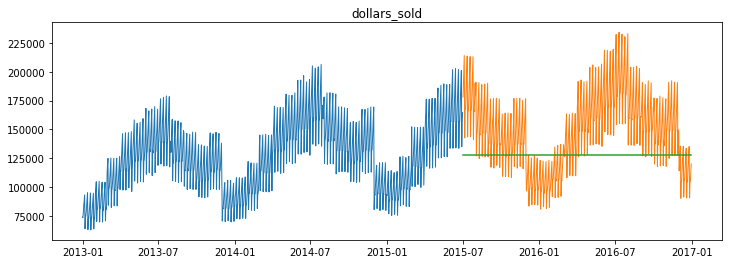

items_sold -- RMSE: 7378


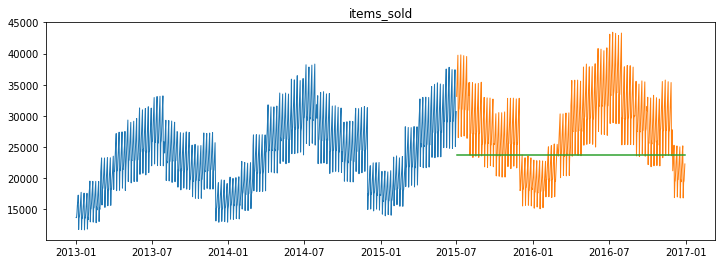

In [181]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [182]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple average', target_var = col)

In [183]:
eval_df

,model_type,target_var,rmse
0,Last Value,items_sold,6621.0
1,Last Value,dollars_sold,35402.0
2,simple average,dollars_sold,39664.0
3,simple average,items_sold,7378.0


___________________________________

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

In [184]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

items = round(train['items_sold'].rolling(period).mean().iloc[-1], 2)
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,items_sold,dollars_sold
ds,,
2015-07-02,31432.77,168957.91
2015-07-03,31432.77,168957.91
2015-07-04,31432.77,168957.91


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 37378


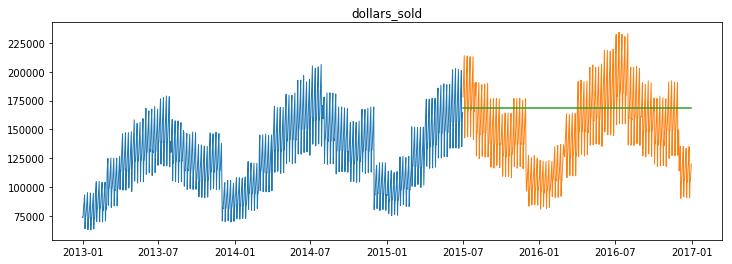

items_sold -- RMSE: 6954


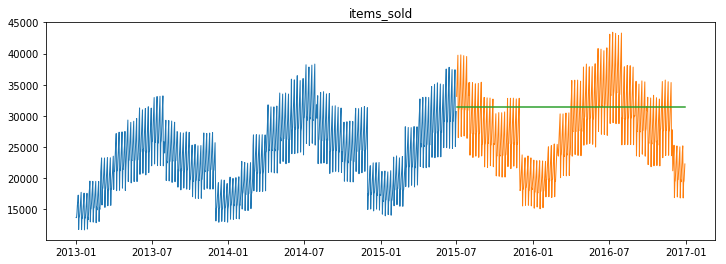

In [185]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [186]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d moving average', target_var = col)

Try different rolling windows

In [187]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    items = round(train['items_sold'].rolling(p).mean().iloc[-1], 2)
    dollars = round(train['dollars_sold'].rolling(p).mean().iloc[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'items_sold'
                            )
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'dollars_sold'
                            )

In [188]:
eval_df

,model_type,target_var,rmse
0,Last Value,items_sold,6621.0
1,Last Value,dollars_sold,35402.0
2,simple average,dollars_sold,39664.0
3,simple average,items_sold,7378.0
4,30d moving average,dollars_sold,37378.0
5,30d moving average,items_sold,6954.0
6,1d moving average,items_sold,6621.0
7,1d moving average,dollars_sold,35402.0
8,4d moving average,items_sold,6592.0
9,4d moving average,dollars_sold,35515.0


Which is best?

In [189]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
16,104d moving average,items_sold,6101.0
17,104d moving average,dollars_sold,32803.0


___________________________________

### Holt's Linear Trend

**Exponential Smoothing**

way to apply weights as time moves on depending on recency.   

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 

**Seasonal Decomposition**

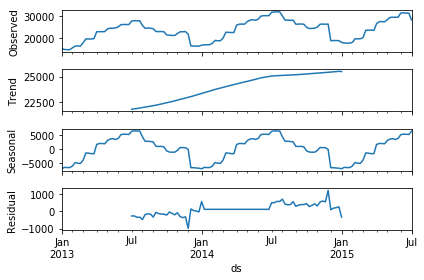

In [190]:
sm.tsa.seasonal_decompose(train['items_sold'].resample('W').mean()).\
    plot()
plt.show()

**Make Predictions**

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [198]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)
    yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/maggiegiust/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [199]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-02,31670.90,170251.51
2015-07-03,31660.56,170200.14
2015-07-04,31650.22,170148.77
2015-07-05,31639.88,170097.41
2015-07-06,31629.54,170046.04


**Plot Actual vs. Predicted Values**

dollars_sold -- RMSE: 34700


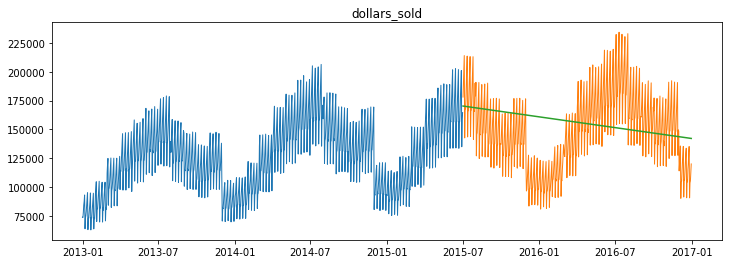

items_sold -- RMSE: 6464


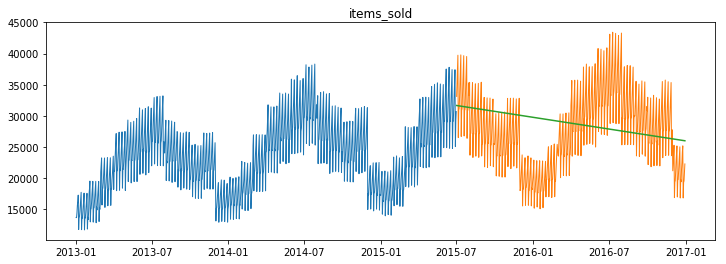

In [200]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [201]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)

In [202]:
eval_df.tail()

,model_type,target_var,rmse
17,104d moving average,dollars_sold,32803.0
18,Holts,dollars_sold,120036.0
19,Holts,items_sold,22797.0
20,Holts,dollars_sold,34700.0
21,Holts,items_sold,6464.0


___________________________________

### Predict Based on Previous Cycle

To predict based on previous cycle, it is best to split our data by date instead of proportions.

In [203]:
df.head()

,dollars_sold,items_sold
ds,,
2013-01-01,73844.01,13696
2013-01-02,73570.58,13678
2013-01-03,78169.48,14488
2013-01-04,84467.73,15677
2013-01-05,87621.85,16237


In [204]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

**Make Predictions**

In [130]:
yhat_df = train['2015'] + train.diff(365).mean()

In [131]:
print(yhat_df.head(1))
print(validate.head(1))

             dollars_sold    items_sold
ds                                     
2015-01-01  104337.620493  19411.813699
            dollars_sold  items_sold
ds                                  
2016-01-01     107875.26       20158


In [132]:
# set yhat_df to index of validate but without 2/29. 
yhat_df.index = validate.index[validate.index != '2016-02-29']

In [133]:
len(yhat_df)

365

In [134]:
# now we need to add 2/29 back in there and we will set the 
# prediction to be that of 2/28. 
# there are multiple ways to do this I'm sure...here's one! 

# reset index so that date is not an index. 
yhat_df = yhat_df.reset_index()

In [136]:
# append the values for 2/28 into a new day 2/29. 
predicted_values_to_append = yhat_df[yhat_df.ds == '2016-02-28'][['dollars_sold', 'items_sold']]

,dollars_sold,items_sold
58,128955.930493,24124.813699


In [140]:
d = pd.Series({'ds': '2016-02-29', 
        'dollars_sold': predicted_values_to_append.dollars_sold,
        'items_sold': predicted_values_to_append.items_sold
       })

yhat_df = yhat_df.append(d, ignore_index = True)

In [141]:
yhat_df.tail()

,ds,dollars_sold,items_sold
361,2016-12-28 00:00:00,96048.7,17754.8
362,2016-12-29 00:00:00,110354,20588.8
363,2016-12-30 00:00:00,109524,20376.8
364,2016-12-31 00:00:00,115721,21562.8
365,2016-02-29,"58 128955.930493 Name: dollars_sold, dtype:...","58 24124.813699 Name: items_sold, dtype: fl..."


In [88]:
# sort by date again to put leap day in where it belongs
yhat_df = yhat_df.sort_values('ds').set_index('ds')

In [96]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2016-01-01,104337.620493,19411.813699
2016-01-02,112870.770493,20904.813699
2016-01-03,118245.300493,21983.813699
2016-01-04,125496.760493,23286.813699
2016-01-05,88551.940493,16420.813699


**Plot and Evaluate**

dollars_sold -- RMSE: 28119


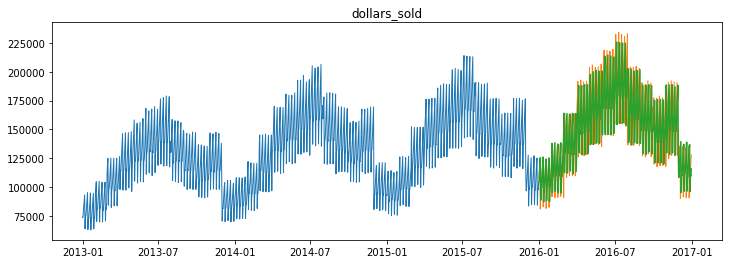

items_sold -- RMSE: 5229


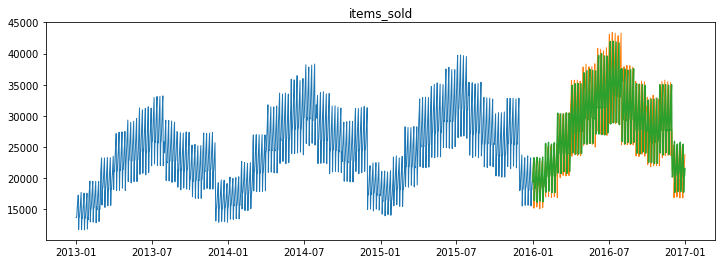

In [97]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

Which model did the best?

In [98]:
# get the min rmse for each variable

min_rmse_dollars_sold = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_items_sold = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_dollars_sold) | 
         (eval_df.rmse == min_rmse_items_sold)
        )]

,model_type,target_var,rmse
20,previous year,dollars_sold,28119.0
21,previous year,items_sold,5229.0


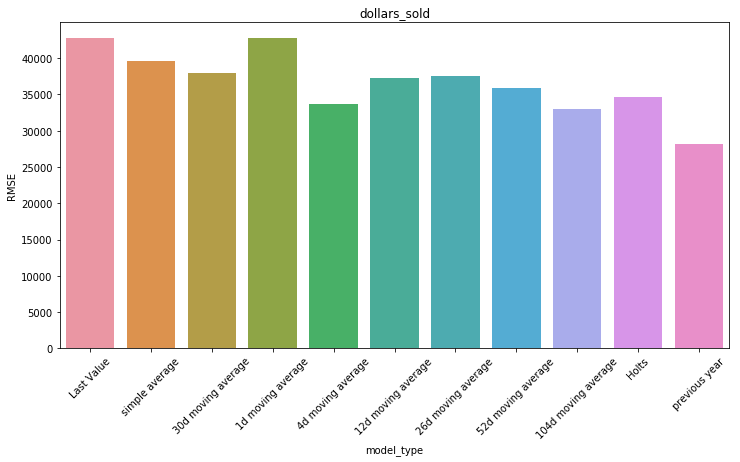

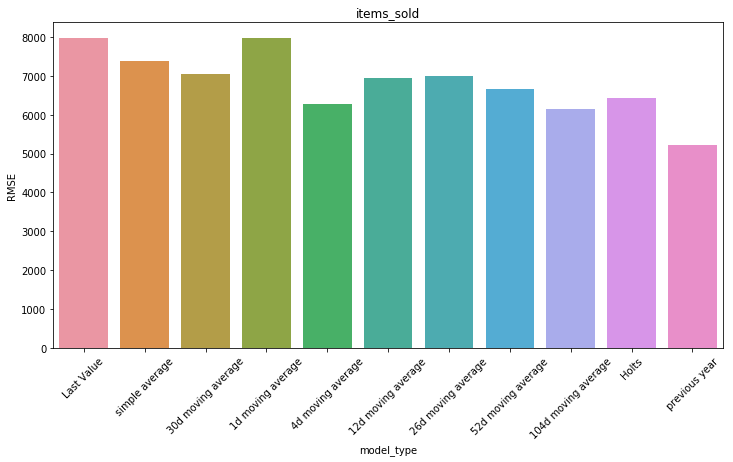

In [115]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [107]:
yhat_df = validate[validate.index != '2016-02-29'] + train.diff(365).mean()
yhat_df.index = test.index

In [108]:
rmse_dollars = round(sqrt(mean_squared_error(test['dollars_sold'], yhat_df['dollars_sold'])), 0)
rmse_items = round(sqrt(mean_squared_error(test['items_sold'], yhat_df['items_sold'])), 0)

In [111]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - dollars_sold:  27115.0
rmse - items_sold:  5041.0


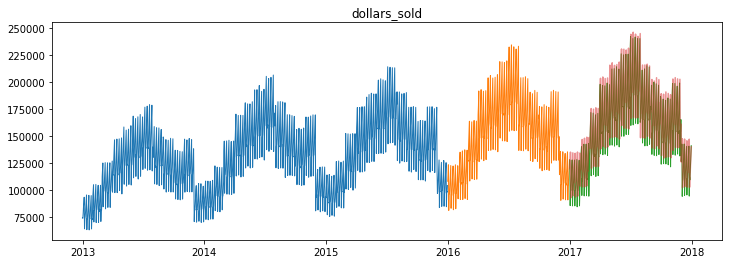

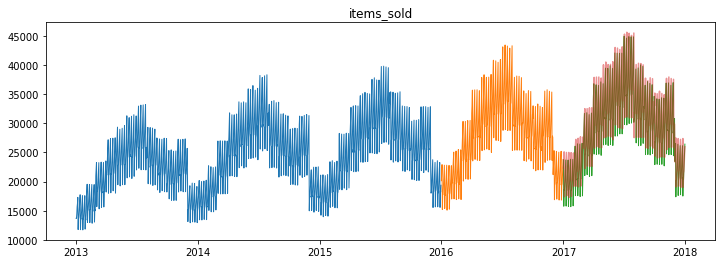

In [113]:
print("rmse - dollars_sold: ", rmse_dollars)
print("rmse - items_sold: ", rmse_items)

for col in train.columns:
    plot_and_eval(col)